# Image classification with MLPs

We will implement an image classifier using MLPs. We will use the MNIST dataset, which consists of greyscale handwritten digits. Each image is 28x28 pixels.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png", width=400, height=200)

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

## Download MNIST with `torchvision`

First up, we need to get our dataset. This is provided through the `torchvision` package. The [torchvision package](https://pytorch.org/docs/stable/torchvision/index.html) consists of popular datasets, model architectures, and common image transformations for computer vision.


In [3]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# I had some problems donwloading the data, and this code was needed to use the data after uploading the Mnist folder with the data.

In [4]:
# first we load the data

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),])


trainset = datasets.MNIST('./drive/MyDrive/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


testset = datasets.MNIST('./drive/MyDrive/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [5]:
### Run this cell only if the previous one does not work. 

#from torchvision import datasets, transforms

# Define a transform to normalize the data
#transform = transforms.Compose([transforms.ToTensor(),
#                             transforms.Normalize((0.5,), (0.5,)),
#                              ])

# Download and load the training  data
#trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
#testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
#testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


We have the training data loaded into `trainloader` and we make that an iterator with `iter(trainloader)`. The batch size of 64 in `trainloader` accounts for the number of images we get in one iteration from the data loader.


This is what one of the images looks like. 

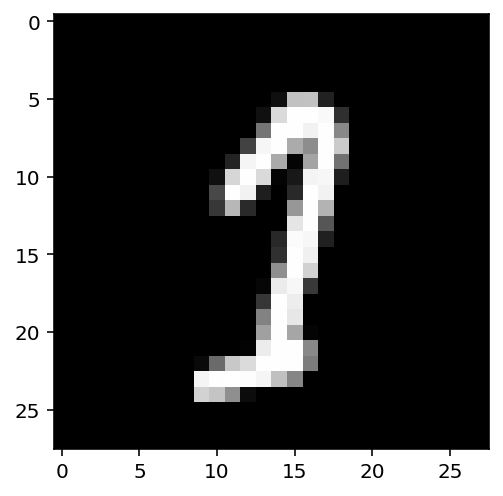

In [7]:
plt.imshow(images[1].numpy().reshape([28,28]), cmap='Greys_r')

## Training a multi-class Logistic Regressor

We will first train a multi-class logistic regressor to evaluate how good it can do in both training and testing. We will use a **softmax** non-linear activation function.


In [8]:
class Multi_LR(nn.Module):
    def __init__(self,dimx,nlabels): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output = nn.Linear(dimx,nlabels)
         
        self.logsoftmax = nn.LogSoftmax(dim=1)   # dim is the dimension along which 
                                                 # Softmax will be computed (so every slice along dim will sum to 1)

        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output(x)
        x = self.logsoftmax(x)
        return x

Now we implement an extension to the class above (which inheritates from `Multi_LR`) that includes a training method.  One thing, note that MNIST images are of dimension $28\times28=784$. To feed this image as the input to a `nn.Linear` layer, it has to be converted to a $784\times 1$ input tensor. 



In [9]:
''' This class inherits from the `Multi_LR` class. So it has the same atributes
and methods, and some others that we will add. 
'''
class Multi_LR_extended(Multi_LR):
    
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,nlabels)  #To initialize `Multi_LR`!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
    def train(self,trainloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:              
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images.view(images.shape[0], -1))

                loss = self.criterion(out, labels)
                
                running_loss += loss.item()

                loss.backward()

                self.optim.step()

              
            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0): # Every epoch

                print("Training loss after %d epochs: %f" %(e+1,self.loss_during_training[-1]))
                
  


In [10]:
my_LR = Multi_LR_extended(dimx=784,nlabels=10,epochs=5,lr=1e-3)

my_LR.train(trainloader)

Training loss after 1 epochs: 0.458829
Training loss after 2 epochs: 0.325127
Training loss after 3 epochs: 0.308903
Training loss after 4 epochs: 0.299555
Training loss after 5 epochs: 0.294126


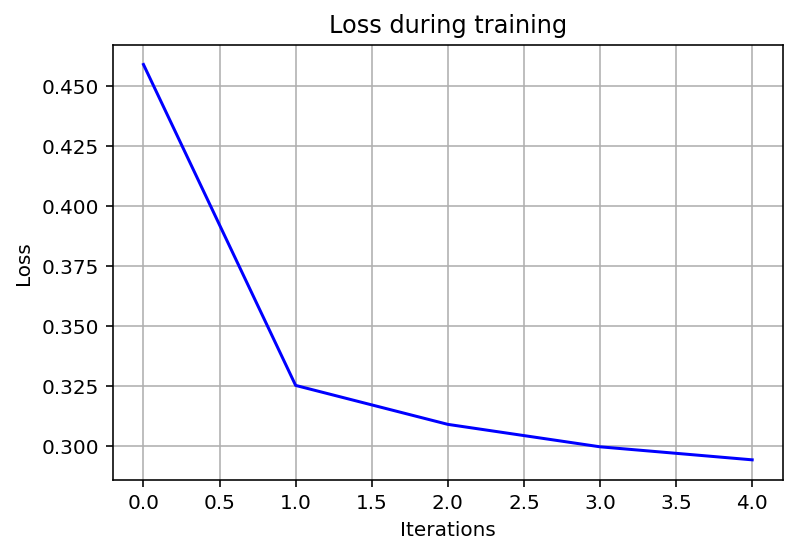

In [11]:
plt.plot(my_LR.loss_during_training,'-b',label='Cross Entropy Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss during training')
plt.grid()

To evaluate the performance across the entire test dataset, we will implement a for loop using `testloader` and compute errors per mini-batch. The following code will do the work:

In [12]:
loss = 0
accuracy = 0

# Turn off gradients for validation, saves memory and computations
with torch.no_grad():

    for images,labels in testloader:
        
        logprobs = my_LR.forward(images.view(images.shape[0], -1)) # We use a log-softmax, so what we get are log-probabilities
        
        top_p, top_class = logprobs.topk(1, dim=1)
        equals = (top_class == labels.view(images.shape[0], 1))
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    

print("Test Accuracy %f" %(accuracy/len(testloader)))

# as we can see, we get a great test accuracy.

Test Accuracy 0.915307


In [14]:
''' This class inherits from the `Multi_LR` class. So it has the same atributes
and methods, and some others that we will add. 
'''
class Multi_LR_extended(Multi_LR):
    
    def __init__(self,dimx,nlabels,epochs=5,lr=0.001):
        
        super().__init__(dimx,nlabels)  #To initialize `Multi_LR`!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()              
        
        # A list to store the loss evolution along training
        
        self.accuracy = [] 

        self.loss_during_training = []
        
    def train(self, trainloader):

        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:              
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images.view(images.shape[0], -1))

                loss = self.criterion(out, labels)
                
                running_loss += loss.item()

                loss.backward()

                self.optim.step()

              
            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0): # Every 10 epochs

                print("Training loss after %d epochs: %f" %(e+1,self.loss_during_training[-1]))

    def evaluate(self, data):         
    
          loss = 0
          accuracy = 0

          with torch.no_grad():

            for images,labels in data:
        
              logprobs = my_LR.forward(images.view(images.shape[0], -1)) # We use a log-softmax, so what we get are log-probabilities
        
              top_p, top_class = logprobs.topk(1, dim=1)
          
              #returns a boolean vector. It is transformed into a real vector in which True is 1.0 and False is 0.0
            
              equals = (top_class == labels.view(images.shape[0], 1))
              accuracy += torch.mean(equals.type(torch.FloatTensor))

          self.accuracy.append(accuracy/len(data))
          
          print("The accuracy is %f" %(self.accuracy[-1]))
              

# this class has a method called evaluate, which can be passed a parameter (tesloader or trainloader) and it will compute the evaluation.

In [15]:
my_LR = Multi_LR_extended(dimx=784,nlabels=16,epochs=10,lr=1e-3)

my_LR.train(trainloader)

print('Training results:')

my_LR.evaluate(trainloader)

print('Testing results:')

my_LR.evaluate(testloader)

Training loss after 1 epochs: 0.466369
Training loss after 2 epochs: 0.325080
Training loss after 3 epochs: 0.309821
Training loss after 4 epochs: 0.300996
Training loss after 5 epochs: 0.293666
Training loss after 6 epochs: 0.291955
Training loss after 7 epochs: 0.286237
Training loss after 8 epochs: 0.285533
Training loss after 9 epochs: 0.282629
Training loss after 10 epochs: 0.278035
Training results:
The accuracy is 0.925706
Testing results:
The accuracy is 0.921477


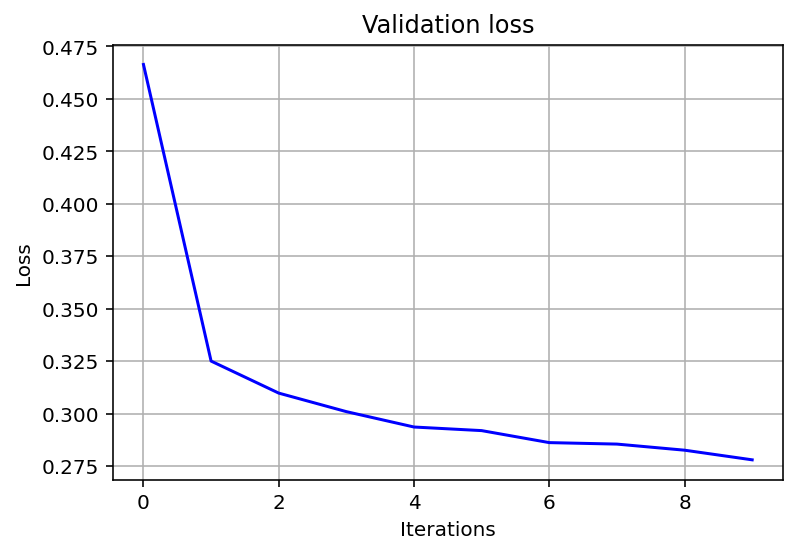

In [16]:
plt.plot(my_LR.loss_during_training,'-b',label='Cross Entropy Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Validation loss')
plt.grid()

we observe that both values are indeed similar, indicating that the model is not overfitting.  

Let's check the values for the weight matrix. For a simpler visualization, we will plot the histogram of all the values in the weight matrix.

In [17]:
print(my_LR.output)

print(my_LR.accuracy)

print(my_LR.parameters) # output, logsoftmax criterion


Linear(in_features=784, out_features=16, bias=True)
[tensor(0.9257), tensor(0.9215)]
<bound method Module.parameters of Multi_LR_extended(
  (output): Linear(in_features=784, out_features=16, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
  (criterion): NLLLoss()
)>


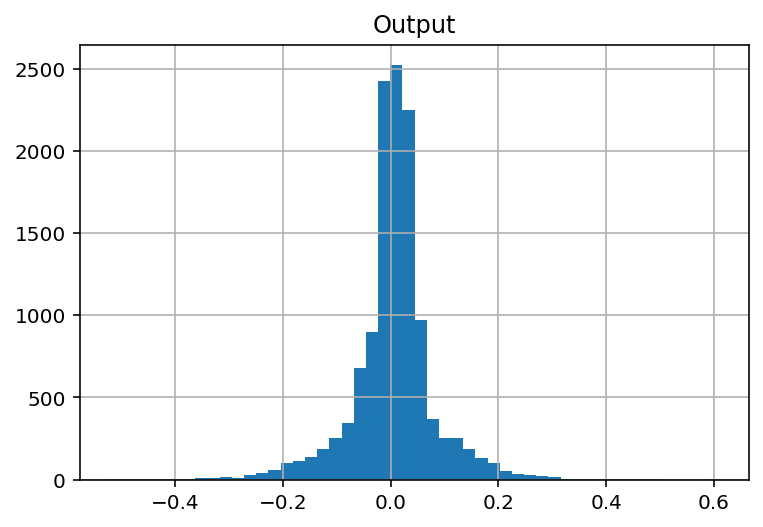

In [18]:
plt.hist(my_LR.output.weight.detach().numpy().reshape([-1,]),50) 
plt.title('Output')
plt.grid()


## Train a MLP to do the same job


For this part, we will train an **MLP** to do the same job. The non-linear activations will be RELUs.

In [22]:
Image(url= "https://pytorch.org/docs/stable/_images/ReLU.png", width=300, height=100)

As with the LR, we create a small class defining the model and then a larger class than inherites from it to incorporate methods to perform both training and model evaluation.



In [23]:
class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,nlabels): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)
        
        self.output3 = nn.Linear(hidden2,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)                                                             
        
    def forward(self, x, out=None):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)

        if out == 1:
          return x

        x = self.output2(x)
        x = self.relu(x)

        if out == 2:
          return x

        x = self.output3(x)
        x = self.logsoftmax(x)
        return x

    # the function forward can take two arguments, 
    # x: a torch object containing the data we are working with.
    # out: an optional variable that returns a specific point of the function.

    

In [24]:
# Now this new class will be used to perform training and model evaluation.

class MLP_extended(MLP):
    
    def __init__(self,dimx,hidden1,hidden2,nlabels,epochs=5,lr=0.001): #Nlabels will be 10 in our case
  
        super().__init__(dimx,hidden1,hidden2,nlabels)  #To initialize `Multi_LR`!
                
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               
                
        self.accuracy = [] 

        self.loss_during_training = []
        
    def train(self, trainloader, p = True):

        for e in range(int(self.epochs)):
                        
            running_loss = 0.
            
            for images, labels in trainloader:              
        
                self.optim.zero_grad()  
            
                out = self.forward(images.view(images.shape[0], -1))

                loss = self.criterion(out, labels)
                
                running_loss += loss.item()

                loss.backward()

                self.optim.step()
              
            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0) and p: 

                print("Training loss after %d epochs: %f" %(e+1,self.loss_during_training[-1]))

    def evaluate(self, data):         
    
          loss = 0
          accuracy = 0
          
          with torch.no_grad():

            for images,labels in data:
        
              logprobs = my_LR.forward(images.view(images.shape[0], -1)) 
        
              top_p, top_class = logprobs.topk(1, dim=1)
              equals = (top_class == labels.view(images.shape[0], 1))
              accuracy += torch.mean(equals.type(torch.FloatTensor))

          self.accuracy.append(accuracy/len(data))
          
          print("The accuracy is %f" %(self.accuracy[-1]))          
     

              

Next up: training the model for 10 epochs and compute the train/test performance. Then plotting the loss during trianing. 

In [25]:
my_LR_extended = MLP_extended(dimx=784, nlabels=10, hidden1=128, hidden2=64, epochs = 10)

my_LR_extended.train(trainloader)

my_LR_extended.evaluate(trainloader)

my_LR_extended.evaluate(testloader)

Training loss after 1 epochs: 0.403297
Training loss after 2 epochs: 0.194947
Training loss after 3 epochs: 0.141739
Training loss after 4 epochs: 0.113858
Training loss after 5 epochs: 0.095809
Training loss after 6 epochs: 0.082563
Training loss after 7 epochs: 0.073722
Training loss after 8 epochs: 0.065474
Training loss after 9 epochs: 0.059195
Training loss after 10 epochs: 0.054998
The accuracy is 0.925673
The accuracy is 0.921775


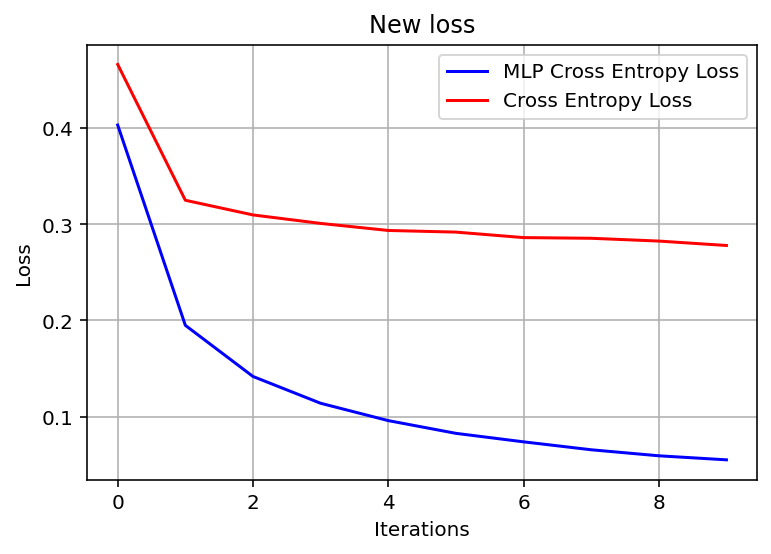

In [26]:
plt.plot(my_LR_extended.loss_during_training,'-b',label='MLP Cross Entropy Loss')
plt.plot(my_LR.loss_during_training, '-r', label = 'Cross Entropy Loss ')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('New loss')
plt.legend()
plt.grid()

Comparing it to Logistic Regressor, it is clear to see that the loss of the MLP (blue) is much lower than the loss of the Logistic Regressor, meaning that the model performs much better!

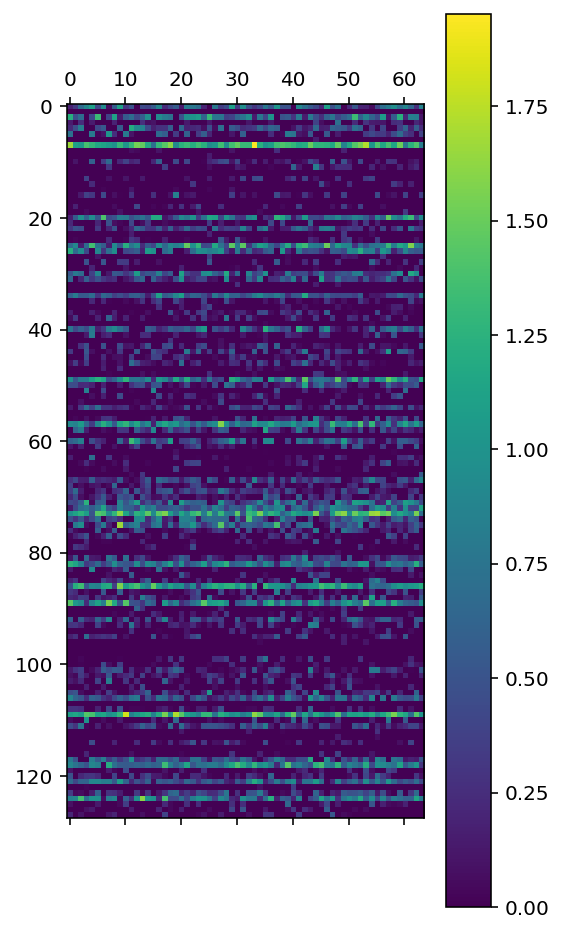

In [27]:
# Visualize the activations at the output of the first layer for a minibatch of test images.

x_test,y_test = next(iter(testloader)) 

size_h1 = 128
size_h2 = 64

# these variables indicate the size of each hidden layer.

# Then, we evaluate the output of the first layer of the network for that mini-batch
activations = torch.zeros(size_h1, size_h2) # a matrix of zeroes that will be updated.

my_MLP = MLP_extended(dimx = 784, hidden1 = size_h1 ,hidden2 = size_h2 ,nlabels=10)

for i in range(size_h2):
  image = x_test[i,:,:,:]
  out = my_MLP.forward(image.view(image.shape[0], -1), 1)
  activations[:,i] = out # modify each column of the activations matrix.

activations = activations.detach().numpy()

# We plot the matrix using matplotlib

plt.matshow(activations)
plt.colorbar()


Plot of the variance of the hidden units across the test mini-batch to better visualize these unactive hidden units. 

There are 9 hidden units that are unactive


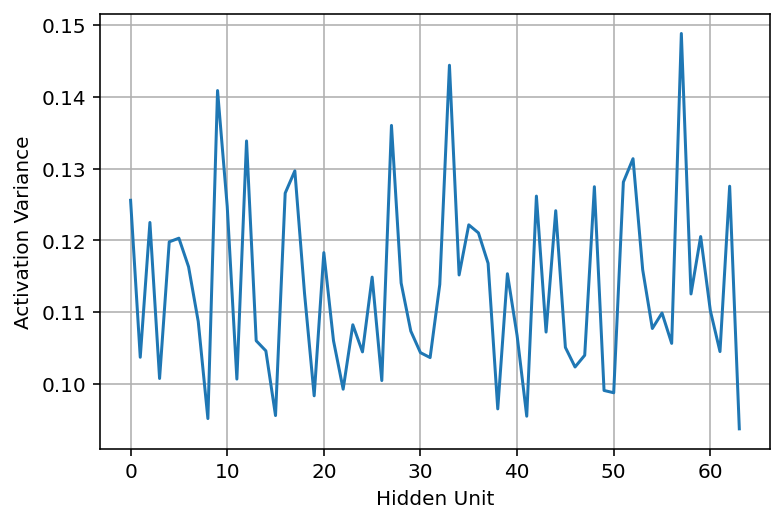

In [28]:
plt.plot(np.var(activations,0))
plt.grid()
plt.xlabel('Hidden Unit')
plt.ylabel('Activation Variance')

new_hidden_units = np.sum(np.var(activations,0)<=0.1)

print("There are {0:d} hidden units that are unactive".format(new_hidden_units))


>It can be noticed that in general, unsued activations are prominent in the first layer compared to the second one. This is in general the case for any NN, as the **loss function is more sensitive to parameter variations in the last layers**, and hence gradients are higher in magnitude. On the contrary, the **loss function is less senstive to parameter variations in the first layers** and hence only very relevant parameters are trained (they influence more in the loss function), while many others vary very little w.r.t. initialization.

In [29]:
new_MLP = MLP_extended(dimx=784, nlabels=10, hidden1=new_hidden_units, hidden2=size_h2, epochs = 10)

new_MLP.train(trainloader)

print('The results for train')

new_MLP.evaluate(trainloader)

print('The results for testing')

new_MLP.evaluate(testloader)

# comparing to the previous results, we can see that actually the results are not much better, and we get similar results.

Training loss after 1 epochs: 0.783246
Training loss after 2 epochs: 0.510621
Training loss after 3 epochs: 0.464168
Training loss after 4 epochs: 0.440505
Training loss after 5 epochs: 0.425805
Training loss after 6 epochs: 0.415025
Training loss after 7 epochs: 0.410338
Training loss after 8 epochs: 0.405040
Training loss after 9 epochs: 0.400205
Training loss after 10 epochs: 0.397181
The results for train
The accuracy is 0.925656
The results for testing
The accuracy is 0.921477


We can see that the accuracy is great for both training and testing

In the first layer, there are 62 hidden units that are unactive
In the second layer, there are 64 hidden units that are unactive


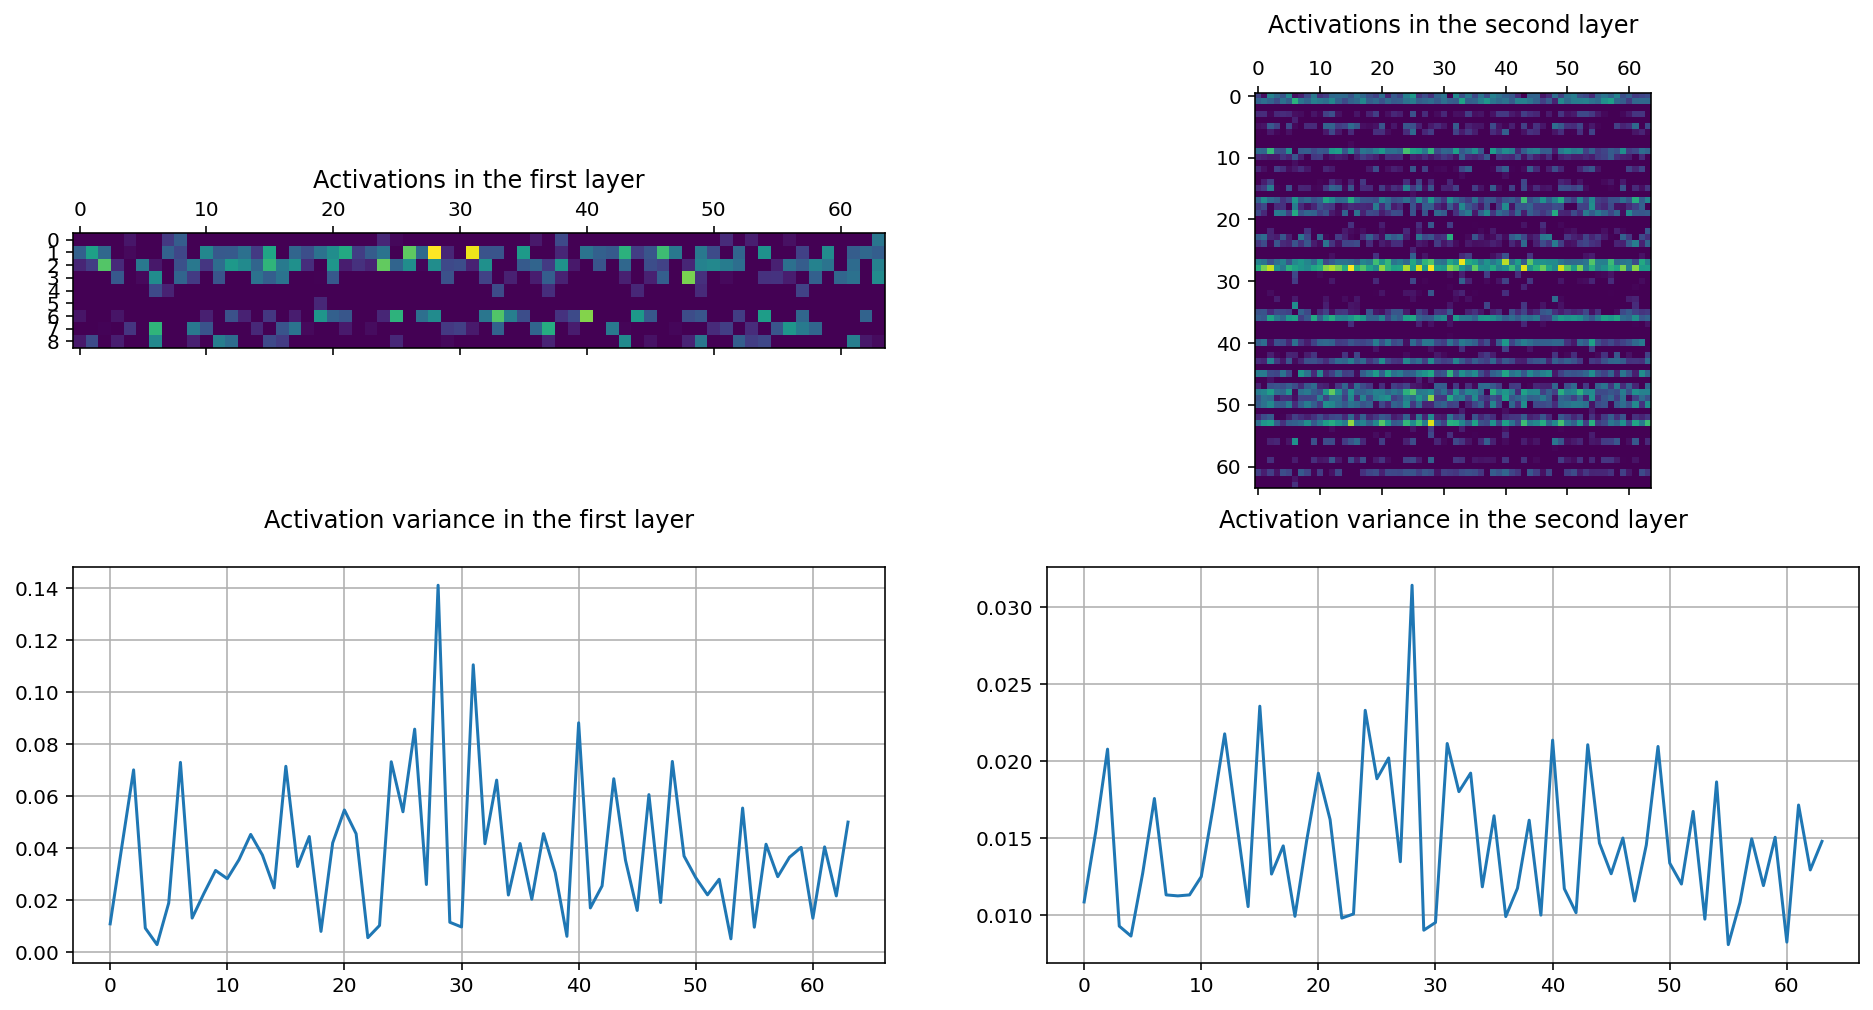

In [50]:
new_MLP = MLP_extended(dimx=784, nlabels=10, hidden1=new_hidden_units, hidden2=size_h2, epochs = 10)

activations_1 = torch.zeros(new_hidden_units, size_h2)

for i in range(size_h2):
  image = x_test[i,:,:,:]
  out = new_MLP.forward(image.view(image.shape[0], -1), 1)
  activations_1[:,i] = out

activations_1 = activations_1.detach().numpy()

activations_2 = torch.zeros(size_h2, size_h2)

for i in range(size_h2):
  image = x_test[i,:,:,:]
  out = new_MLP.forward(image.view(image.shape[0], -1), 2)
  activations_2[:,i] = out

activations_2 = activations_2.detach().numpy()


# Then, we evaluate the output of the first layer of the network for that mini-batch

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(16, 8))
im = ax[0,0].matshow(activations_1)
ax[0,0].set_title('Activations in the first layer\n')

ax[0,1].matshow(activations_2)
ax[0,1].set_title('Activations in the second layer\n')

ax[1,0].plot(np.var(activations_1,0))
ax[1,0].set_title('Activation variance in the first layer\n')
ax[1,0].grid()

ax[1,1].plot(np.var(activations_2,0))
ax[1,1].set_title('Activation variance in the second layer\n')
ax[1,1].grid()

print("In the first layer, there are {0:d} hidden units that are unactive".format(np.sum(np.var(activations_1,0)<=0.1)))

print("In the second layer, there are {0:d} hidden units that are unactive".format(np.sum(np.var(activations_2,0)<=0.1)))

We can see that the activation variance in the second layer is lower, and there are a lot of hidden units in both layers. We will compute the results for another model to see the differences: